In [112]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import copy
from textwrap import wrap
from magnitude_threshold import abs_sobel_thresh,mag_thresh,dir_threshold
%matplotlib inline

In [113]:
def sv_color_thresholds(image,sthresh=(0,255),vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    sv_binary = np.zeros_like(s_channel)
    sv_binary[(s_binary == 1) & ( v_binary == 1)] = 1
    return sv_binary
    

def s_color_thresholds(image,sthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    return s_binary   

In [114]:
def color_and_gradient(image):
    color_and_gradient_binary = np.zeros_like(image[:,:,0])
    ksize = 3
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(25, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.4))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
   
    #sv_binary = sv_color_thresholds(undistort_test_image,(100,255),(50,255))
    s_binary = s_color_thresholds(image,(150,255))
    
    color_and_gradient_binary[(s_binary == 1) | (combined == 1)] = 1
    
    return color_and_gradient_binary


In [115]:
def perspective_transform(image):
    img = image
    img_size = (img.shape[1], img.shape[0])
    bot_width = .76
    mid_width = .08
    height_pct = .62 
    bottom_trim = .935
    offset = img_size[0]*.21
   
    top_left = p1 = [img.shape[1]*(.5 - mid_width/2), img.shape[0]*height_pct]
    top_right = p2 = [img.shape[1]*(.5 + mid_width/2), img.shape[0]*height_pct]
    bottom_right = p3 = [img.shape[1]*(.5 + bot_width/2), img.shape[0]*bottom_trim]
    bottom_left = p4 = [img.shape[1]*(.5 - bot_width/2), img.shape[0]*bottom_trim]
    #print( " p1 {} p2 {} p3 {} p4 {} ".format(p1,p2,p3,p4))
    src = np.float32([p1,p2,p3,p4])
    dst_p1 = [offset, 0]
    dst_p2 = [img_size[0] - offset, 0]
    dst_p3 = [img_size[0] - offset, img_size[1]]
    dst_p4 = [offset, img_size[1]]
    dst = np.float32([dst_p1,dst_p2 ,dst_p3 ,dst_p4 ])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # inverse matrix
    invM = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    
    return warped, M, invM
                                 

#### Locate the Lane Lines and Fit a Polynomial

In [116]:
class LocateLaneLines():

    
    def __init__(self):
            self.left_lane_inds = None
            self.right_lane_inds = None 
            self.leftx_base = None
            self.rightx_base = None
            self.left_fit = None
            self.right_fit = None
            
            
            
    def  locate_lane_lines(self,binary_warped,nwindows=9,margin=100,minpix=50):
            # ideal to check if binary_warped image and stored image are same
            # based on that we decide to use sliding window or just use
            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
            # Create an output image to draw on and  visualize the result
            #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            #print ( "midpoint ", midpoint )
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            #print( "self.leftx_base ", self.leftx_base, "self.rightx_base", self.rightx_base )
            self.leftx_base = leftx_base
            self.rightx_base = rightx_base
            #print( "leftx_base ", leftx_base, "rightx_base", rightx_base )
            return  self.locate_lane_lines_new_frame(binary_warped,leftx_base,rightx_base)
            
            
        
    def locate_lane_lines_same_frame(self,binary_warped,margin=100):
            # Assume you now have a new warped binary image 
            # from the next frame of video (also called "binary_warped")
            # It's now much easier to find line pixels!
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = margin
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
            left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
            left_fit[1]*nonzeroy + left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
            right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            return left_lane_inds,right_lane_inds,left_fit,right_fit
    
    def locate_lane_lines_new_frame(self,binary_warped,leftx_current,rightx_current,nwindows=9,margin=110,minpix=50):
            #print("Begin locate_lane_lines_new_frame")
            # Create an output image to draw on and  visualize the result
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            # Choose the number of sliding windows
            nwindows = nwindows
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            #leftx_current = leftx_base
            #rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = margin
            # Set minimum number of pixels found to recenter window
            minpix = minpix
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            #print("left lane inds " , len(left_lane_inds))
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            #print("left lane inds " , len(left_lane_inds))

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            self.left_lane_inds = list(left_lane_inds)
            self.right_lane_inds = list(right_lane_inds) 
            self.left_fit = copy.deepcopy(left_fit)
            self.right_fit = copy.deepcopy(right_fit)
            #print("End locate_lane_lines_new_frame")
            return left_lane_inds,right_lane_inds,left_fit,right_fit
    
    def measure_lane_lines_curvature_in_pixel_space(self,binary_warped):
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            # Define y-value where we want radius of curvature
            # I'll choose the maximum y-value, corresponding to the bottom of the image
            left_fit = self.left_fit
            right_fit = self.right_fit
            y_eval = np.max(ploty)
            left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
            right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
            print(left_curverad, right_curverad)
            
    def measure_lane_lines_curvature_in_real_world_space(self,binary_warped):
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            # Define conversions in x and y from pixels space to meters
            ym_per_pix = 30/720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            leftx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
            #lefty = nonzeroy[left_lane_inds] 
            rightx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
            #righty = nonzeroy[right_lane_inds]
            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
            # Calculate the new radii of curvature
            y_eval = np.max(ploty)
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            # Now our radius of curvature is in meters
            #print(left_curverad, 'm', right_curverad, 'm')
            
            # Calculate vehicle center
            #left_lane and right lane bottom in pixels
            left_lane_bottom = (self.left_fit[0]*y_eval)**2 + self.left_fit[1]*y_eval + self.left_fit[2]
            right_lane_bottom = (self.right_fit[0]*y_eval)**2 + self.right_fit[1]*y_eval + self.right_fit[2]
    
            # Lane center as mid of left and right lane bottom                        
            lane_center = (left_lane_bottom + right_lane_bottom)/2.
            image_center = binary_warped.shape[1]/2
            #print ( "lane center ",lane_center)
            #print ( "center image ",center_image)
            center = (lane_center - image_center)*xm_per_pix #Convert to meters
            #print ("center ", center )
            return left_curverad,right_curverad,center
        
    def print_lane_lines_polyfit(self):
            print("left fit ",self.left_fit)
            print("right fit",self.right_fit)
            
    def left_right_lane_lines_polyfit(self):
        return(self.left_fit,self.right_fit)


In [117]:
dist_pickle = np.load(open("camera_cal/dist_pickle.p","rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [118]:
def output_images(image,image_name,idx):
    write_name = 'output_images/'+image_name+str(idx)+'.jpg'
    if(len(image.shape)<3):
        cv2.imwrite(write_name,cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
    elif len(image.shape)==3:
        #print ('Color(RGB)', image.shape)
        cv2.imwrite(write_name,cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    else:
        print("not sure")
    
    #print(undistorted_image.shape)
    

In [119]:
def show_images_inline(orignal_image,undistorted_image,color_and_gradient_image,warped_image,lane_lines_image,lane_lines_area_image,fname,idx):
    print(fname)
    f, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(orignal_image)
    ax1.set_title("\n".join(wrap('Original Image',20)),fontsize=30)
    ax2.imshow(undistorted_image)
    ax2.set_title("\n".join(wrap('Undistort Image',20)),fontsize=30)
    ax3.imshow(color_and_gradient_image, cmap='gray')
    ax3.set_title("\n".join(wrap('color and combined magnitude',20)),fontsize=30)
    
    ax4.imshow(warped_image, cmap='gray')
    ax4.set_title("\n".join(wrap('warped',20)),fontsize=30)
   
    ax5.imshow(lane_lines_image)
    ax5.set_title("\n".join(wrap('lane lines',20)),fontsize=30)
    
    ax6.imshow(lane_lines_area_image)
    ax6.set_title("\n".join(wrap('lane lines area',20)),fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    fstart_len = fname.find('/') + 1
    f.savefig('output_images/'+fname[fstart_len:])

In [120]:
def visualize_lane_lines(left_fit,right_fit,left_lane_inds,right_lane_inds,binary_warped,show_image=False):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if show_image == True:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
   
    return out_img

In [121]:
def undistorted_image_with_lane_area_drawn(left_fit,right_fit,left_curverad,right_curverad,center,undistorted_image,warped_image,Minv,image_show=False):
    warped = warped_image
    undist = undistorted_image
    image = undistorted_image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
     # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255,255,0)
    fontScale = 1
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Vehicle is {:.2f}m of center'.format(center), (50, 190), font, fontScale, fontColor, 2)
    if image_show == True:
        plt.imshow(result)
        plt.show()
    return result

test_images/straight_lines1.jpg


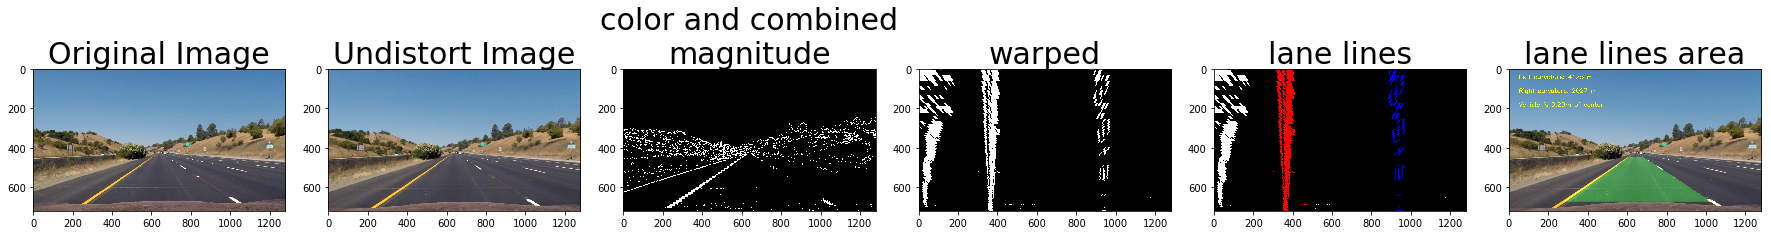

test_images/straight_lines2.jpg


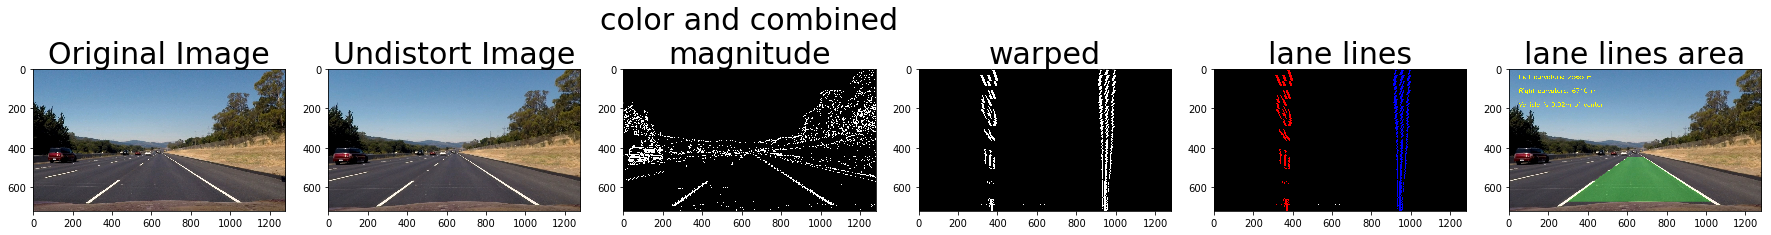

test_images/test1.jpg


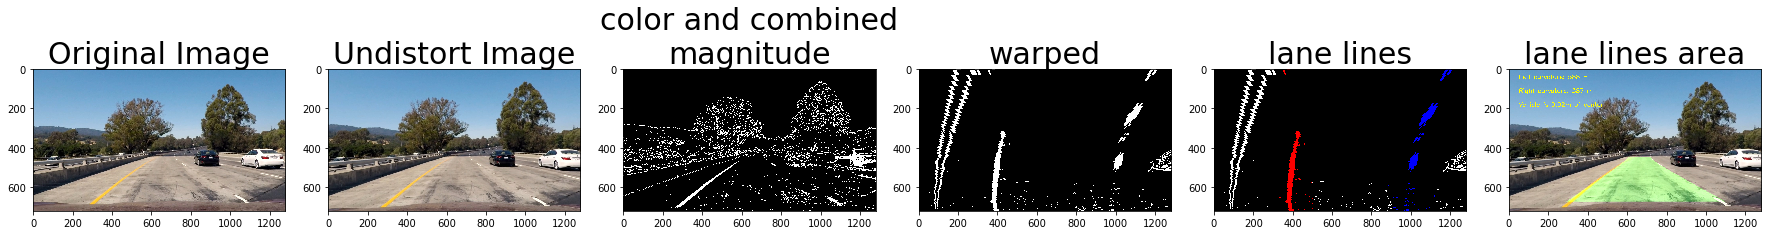

test_images/test2.jpg


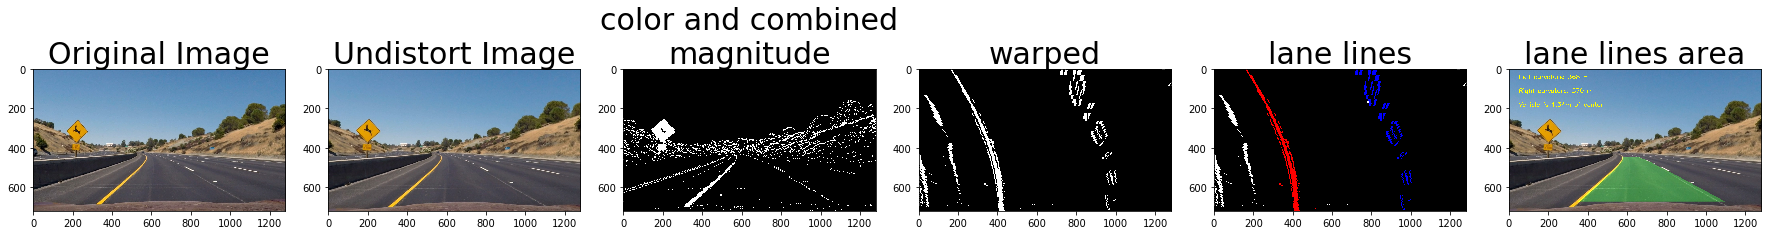

test_images/test3.jpg


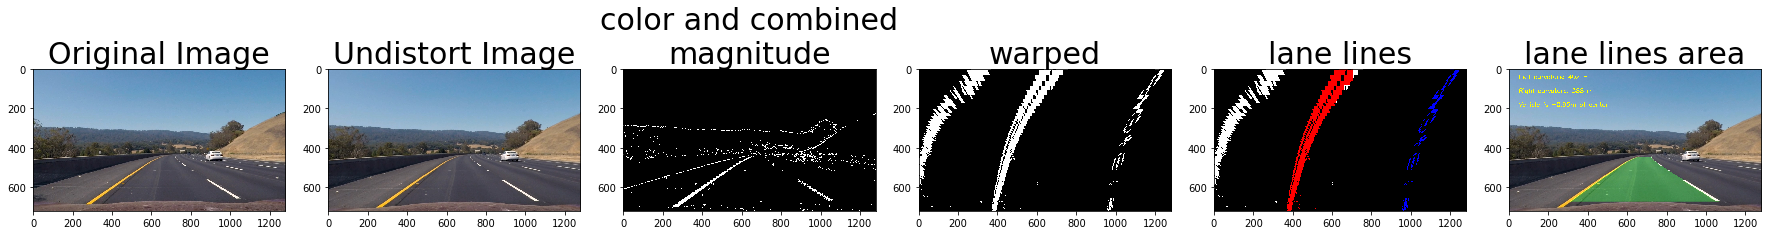

test_images/test4.jpg


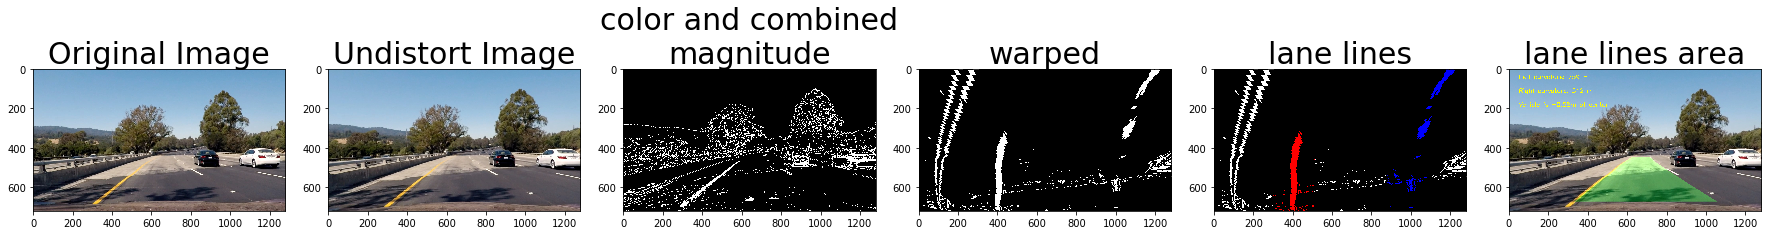

test_images/test5.jpg


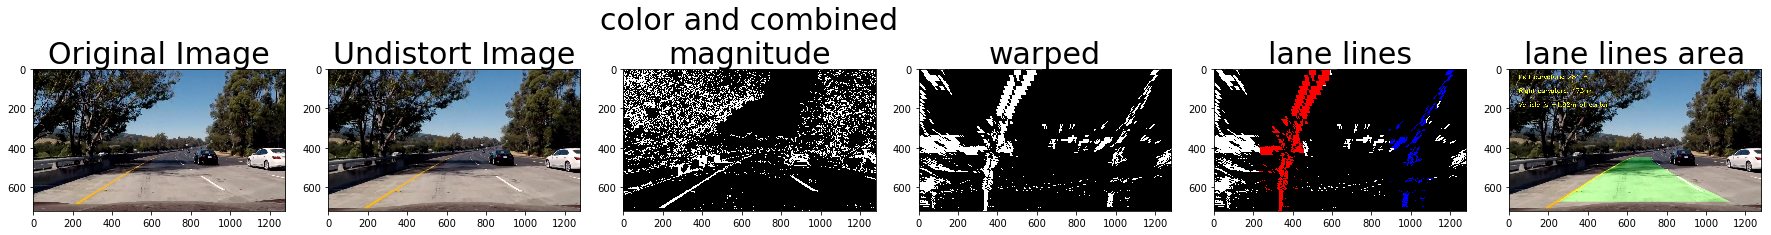

test_images/test6.jpg


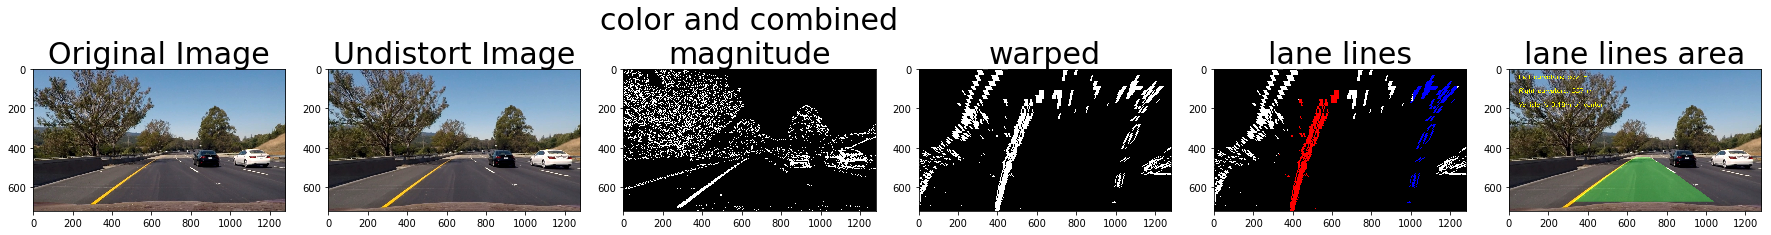

In [122]:
debug=True
#debug=False
output=False
test_images = glob.glob('test_images/*.jpg')
test_image_lane_lines = LocateLaneLines()
for idx, fname in enumerate(test_images,1):
    bgr_test_img = cv2.imread(fname)
    rgb_test_img = cv2.cvtColor(np.copy(bgr_test_img), cv2.COLOR_BGR2RGB)
    undistorted_image = cv2.undistort(rgb_test_img, mtx, dist, None, mtx)
    
    if output == True:
        output_images(undistorted_image,"undistorted_image",idx)
    
    color_and_gradient_image = color_and_gradient(undistorted_image)
    
    if output == True:
        output_images(color_and_gradient_image,"color_and_gradient_image",idx)
    
    warped_image, perspective_matrix,inverse_perspective_matrix = perspective_transform(color_and_gradient_image)
    
    if output == True:
        output_images(warped_image,"warped_image",idx)
    
    left_lane_inds,right_lane_inds,left_fit,right_fit = test_image_lane_lines.locate_lane_lines(warped_image)
    
    
   
    
    lane_lines_image = visualize_lane_lines(left_fit,right_fit,left_lane_inds,right_lane_inds,warped_image)
    
    if output == True:
        output_images(lane_lines_image,"lane_lines_image",idx)
    
    left_curverad,right_curverad,center=test_image_lane_lines.measure_lane_lines_curvature_in_real_world_space(warped_image)
    
    lane_lines_area_image = undistorted_image_with_lane_area_drawn(left_fit,right_fit,left_curverad,right_curverad,center,undistorted_image,warped_image,inverse_perspective_matrix)
    
    if output == True:
        output_images(lane_lines_area_image,"lane_lines_area_image",idx)
        
    
    if debug == True:
        show_images_inline(rgb_test_img,undistorted_image,color_and_gradient_image,warped_image,lane_lines_image,lane_lines_area_image,fname,idx)
        
    
    
   

In [126]:
test_video_lane_lines = LocateLaneLines()

def process_image(image):
    #print(test_video_lane_lines)
    undistorted_image = cv2.undistort(np.copy(image), mtx, dist, None, mtx)
    
    color_and_gradient_image = color_and_gradient(undistorted_image)
    
    warped_image, perspective_matrix,inverse_perspective_matrix = perspective_transform(color_and_gradient_image)
    
    left_lane_inds,right_lane_inds,left_fit,right_fit = test_video_lane_lines.locate_lane_lines(warped_image)
    
    left_curverad,right_curverad,center=test_video_lane_lines.measure_lane_lines_curvature_in_real_world_space(warped_image)
    
    result = undistorted_image_with_lane_area_drawn(left_fit,right_fit,left_curverad,right_curverad,center,undistorted_image,warped_image,inverse_perspective_matrix)
    #plt.imshow(result)
    #plt.show()
    return result

In [127]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [128]:
test_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [05:46<00:00,  3.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 5min 7s, sys: 1min 16s, total: 6min 24s
Wall time: 5min 48s
